<a href="https://colab.research.google.com/github/BenoitProst/act102_actuariat-vie/blob/main/Table_mortalit%C3%A9_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Lien Github du Notebook](https://github.com/BenoitProst/act102_actuariat-vie/blob/b8fee77a4ad21964bda824a820dfda668c017afc/Table_mortalit%C3%A9_Titanic.ipynb)

In [1]:
import pandas as pd

In [ ]:
chemin_fichier = "/content/drive/MyDrive/Développement compétences/CNAM Master 1 actuariat/ACT102 - Actuariat Vie/titanic_train.csv"

Chargement du fichier Titanic dans un dataframe Pandas

In [ ]:
df = pd.read_csv(chemin_fichier, sep=';')

On remarque que certains ages ne sont pas des entiers sur l'année.
Création d'intervalles d'un an

In [ ]:
bornes_age_par_an = list(range(0, 101))

In [ ]:
df['Age_par_an'] = pd.cut(df['Age'], bins=bornes_age_par_an, right=False)

On compte le nombre de passagers, la population, par age, sexe et classe

In [ ]:
df_exposition = df.groupby(['Age_par_an', 'Sex', 'Pclass']).size().reset_index(name='nombre_passager')

On fait la même approche avec les survivants

In [ ]:
df_survivant = df.groupby(['Age_par_an', 'Sex', 'Pclass'])['Survived'].sum().reset_index()

On fusionne les deux taleaux sur age, sexe et classe

In [ ]:
df_survie = pd.merge(df_exposition, df_survivant, on=['Age_par_an', 'Sex', 'Pclass'], how='inner')

On calcule ainsi le taux de survie $p_{x}$ avec le nombre de survivants sur le nombre de passagers

In [ ]:
df_survie['Px']=df_survie['Survived']/df_survie['nombre_passager']

Regardons la probabilité de survie de Jack, 15ans, voyageant en 3ème classe

In [ ]:
df_survie[df_survie['Age_par_an']== pd.Interval(15, 16, closed='left')]

,Age_par_an,Sex,Pclass,nombre_passager,Survived,Px
90,"[15, 16)",female,1,1,1,1.0
91,"[15, 16)",female,2,0,0,NaN
92,"[15, 16)",female,3,3,3,1.0
93,"[15, 16)",male,1,0,0,NaN
94,"[15, 16)",male,2,0,0,NaN
95,"[15, 16)",male,3,1,0,0.0


Sur la ligne 95, on peut voir qu'elle est de 0, qu'importe de quel port il embarque.
Donc si l'Olympic fait naufrage, on peut en déduire que Jack meurt de façon quasi certaine.

Ainsi sur la traversé, la probabilité de décès de Jack est de 10% (= probabilité de naufrage).

Si Jack veut assurer un capital de 100 000€ en cas de décès, la prime pure est **10 000€**.

Regardons maintenant la probabilité de survie de Rose, 17ans, voyageant en 1ère classe

In [ ]:
df_survie[df_survie['Age_par_an']== pd.Interval(17, 18, closed='left')]

,Age_par_an,Sex,Pclass,nombre_passager,Survived,Px
102,"[17, 18)",female,1,2,2,1.0
103,"[17, 18)",female,2,2,2,1.0
104,"[17, 18)",female,3,2,1,0.5
105,"[17, 18)",male,1,1,1,1.0
106,"[17, 18)",male,2,0,0,NaN
107,"[17, 18)",male,3,6,0,0.0


Sur la ligne 102, on peut noter que sa probabilité de survie est de 100% en cas de naufrage. Sa prime pure est donc nulle.

Rose a donc **peu d'intérêt** de s'assurer.

Ses résultats sont à relativiser par rapport au faible nombre de personnes dans l'échantillon analysé.

# Faisons un modèle de GLM

In [47]:
import pandas as pd
#import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
# Supposons que vous avez un fichier CSV appelé 'titanic.csv'
titanic_df = sns.load_dataset('titanic')


In [49]:
titanic_df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [50]:
# Sélectionnez les caractéristiques que vous souhaitez inclure dans le modèle
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

# Sélectionnez la variable cible
target = 'survived'

# Filtrer les lignes avec des valeurs manquantes
titanic_df = titanic_df[features + [target]].dropna()

# Convertir les variables catégorielles en variables indicatrices (dummy variables)
titanic_df = pd.get_dummies(titanic_df, columns=['sex', 'embarked'], drop_first=True)

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(titanic_df.drop(target, axis=1), titanic_df[target], test_size=0.2, random_state=42)


In [51]:
# Ajoutez une colonne de constante à X_train si vous ajustez une régression avec une constante
# X_train = sm.add_constant(X_train)

# Définissez le modèle GLM
model = sm.GLM(y_train, X_train, family=sm.families.Binomial())

# Ajustez le modèle aux données d'entraînement
results = model.fit()

# Affichez un résumé des résultats
print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                  569
Model:                            GLM   Df Residuals:                      561
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -282.48
Date:                Sun, 03 Mar 2024   Deviance:                       564.96
Time:                        18:46:11   Pearson chi2:                     587.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2948
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pclass        -0.0638      0.113     -0.564      0.5

## Création d'un dataframe avec les paramètres de Jack en fonction de l'age

In [30]:
# Créer une liste des âges de 0 à 100 ans
ages = list(range(101))

# Créer un DataFrame pandas avec une colonne 'Age'
df_Jack = pd.DataFrame({'age': ages})
df_Jack['pclass'] = 3
df_Jack['sibsp'] = 0
df_Jack['parch'] = 0
df_Jack['fare'] = 20
df_Jack['sex_male'] = 1
df_Jack['embarked_Q'] = 0
df_Jack['embarked_S'] = 1

# Afficher les premières lignes du DataFrame
df_Jack

,age,pclass,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0,3,0,0,20,1,0,1
1,1,3,0,0,20,1,0,1
2,2,3,0,0,20,1,0,1
3,3,3,0,0,20,1,0,1
4,4,3,0,0,20,1,0,1
...,...,...,...,...,...,...,...,...
96,96,3,0,0,20,1,0,1
97,97,3,0,0,20,1,0,1
98,98,3,0,0,20,1,0,1
99,99,3,0,0,20,1,0,1


In [33]:
predictions_Jack = results.predict(df_Jack)

In [36]:
df_Jack['Px'] = predictions_Jack

In [37]:
df_Jack

,age,pclass,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,Px
0,0,3,0,0,20,1,0,1,0.186081
1,1,3,0,0,20,1,0,1,0.176608
2,2,3,0,0,20,1,0,1,0.167518
3,3,3,0,0,20,1,0,1,0.158805
4,4,3,0,0,20,1,0,1,0.150464
...,...,...,...,...,...,...,...,...,...
96,96,3,0,0,20,1,0,1,0.000499
97,97,3,0,0,20,1,0,1,0.000468
98,98,3,0,0,20,1,0,1,0.000439
99,99,3,0,0,20,1,0,1,0.000412


## Créons le même dataframe avec les paramètres de Rose

In [38]:
# Créer une liste des âges de 0 à 100 ans
ages = list(range(101))

# Créer un DataFrame pandas avec une colonne 'Age'
df_Rose = pd.DataFrame({'age': ages})
df_Rose['pclass'] = 1
df_Rose['sibsp'] = 0
df_Rose['parch'] = 1
df_Rose['fare'] = 100
df_Rose['sex_male'] = 0
df_Rose['embarked_Q'] = 0
df_Rose['embarked_S'] = 1

# Afficher les premières lignes du DataFrame
df_Rose

,age,pclass,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0,1,0,1,100,0,0,1
1,1,1,0,1,100,0,0,1
2,2,1,0,1,100,0,0,1
3,3,1,0,1,100,0,0,1
4,4,1,0,1,100,0,0,1
...,...,...,...,...,...,...,...,...
96,96,1,0,1,100,0,0,1
97,97,1,0,1,100,0,0,1
98,98,1,0,1,100,0,0,1
99,99,1,0,1,100,0,0,1


In [39]:
predictions_Rose = results.predict(df_Rose)

In [40]:
df_Rose['Px'] = predictions_Rose

In [41]:
df_Rose

,age,pclass,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,Px
0,0,1,0,1,100,0,0,1,0.897967
1,1,1,0,1,100,0,0,1,0.891969
2,2,1,0,1,100,0,0,1,0.885663
3,3,1,0,1,100,0,0,1,0.879039
4,4,1,0,1,100,0,0,1,0.872088
...,...,...,...,...,...,...,...,...,...
96,96,1,0,1,100,0,0,1,0.018852
97,97,1,0,1,100,0,0,1,0.017707
98,98,1,0,1,100,0,0,1,0.016631
99,99,1,0,1,100,0,0,1,0.015618


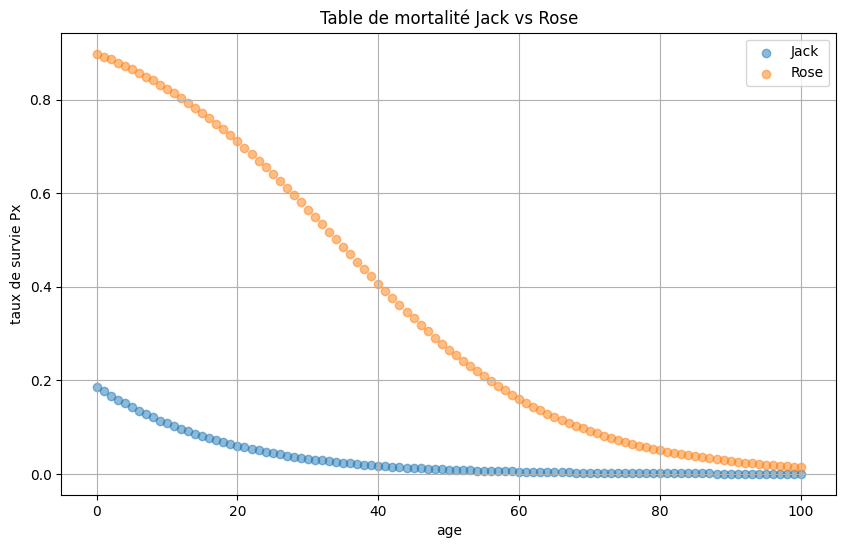

In [46]:

# Créer un graphique
plt.figure(figsize=(10, 6))

# Tracer les prédictions par rapport aux observations réelles
plt.scatter(df_Jack['age'], df_Jack['Px'], alpha=0.5,label='Jack')
plt.scatter(df_Rose['age'], df_Rose['Px'], alpha=0.5,label='Rose')
plt.xlabel('age')
plt.ylabel('taux de survie Px')
plt.title('Table de mortalité Jack vs Rose')
plt.legend()
plt.grid(True)


# Afficher le graphique
plt.show()

## Taux de survie de Jack en cas de naufrage

In [54]:
df_Jack[df_Jack['age']==15]

,age,pclass,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,Px
15,15,3,0,0,20,1,0,1,0.08069


## Taux de survie de Rose en cas de naufrage

In [55]:
df_Rose[df_Rose['age']==17]

,age,pclass,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,Px
17,17,1,0,1,100,0,0,1,0.748355
